<a href="https://colab.research.google.com/github/bansalhim/Deep-learning-assignment/blob/main/Assignment7my_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training: 2-layer relu sgd


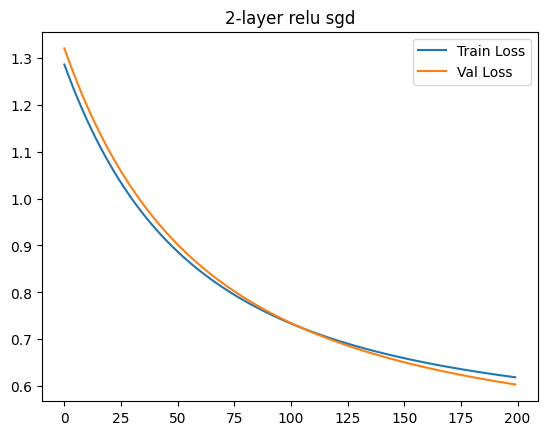

Training: 2-layer relu momentum


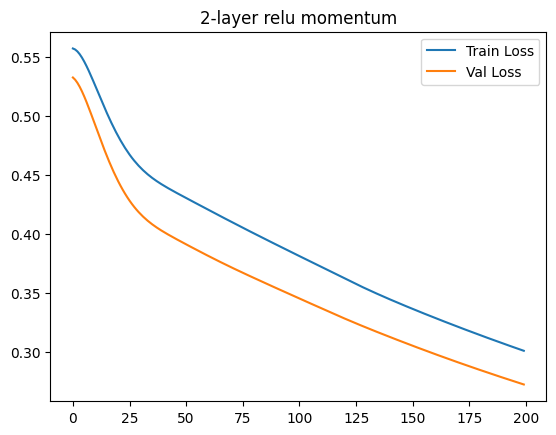

Training: 2-layer sigmoid sgd


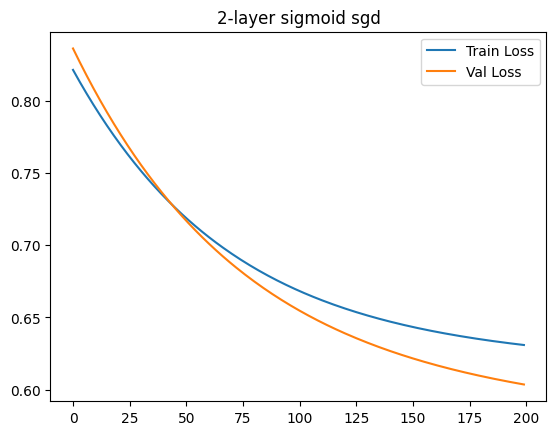

Training: 2-layer sigmoid momentum


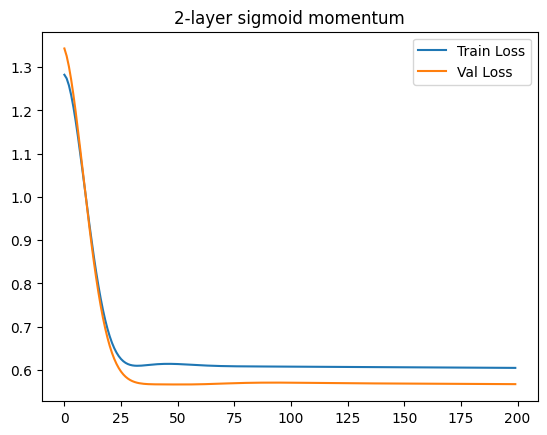

Training: 5-layer relu sgd


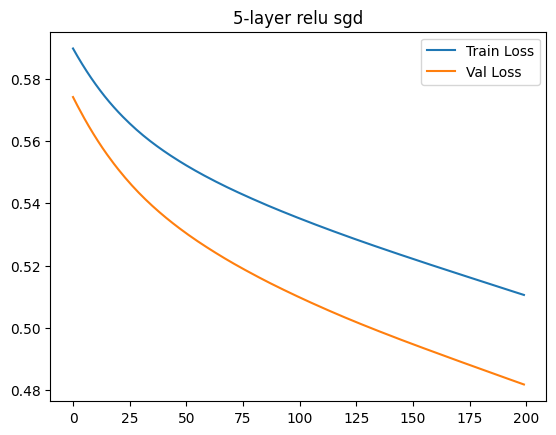

Training: 5-layer relu momentum


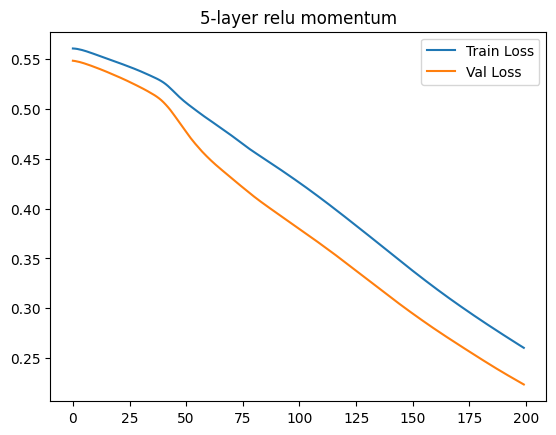

Training: 5-layer sigmoid sgd


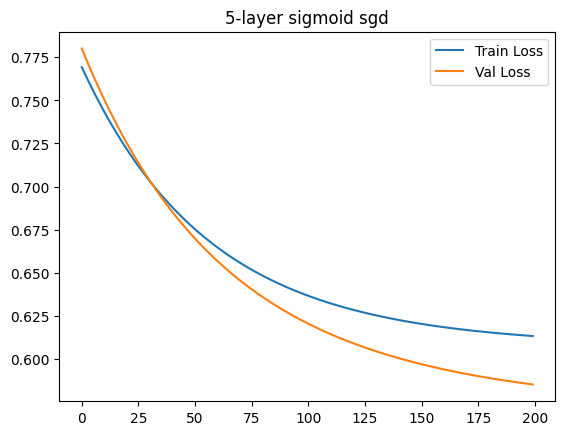

Training: 5-layer sigmoid momentum


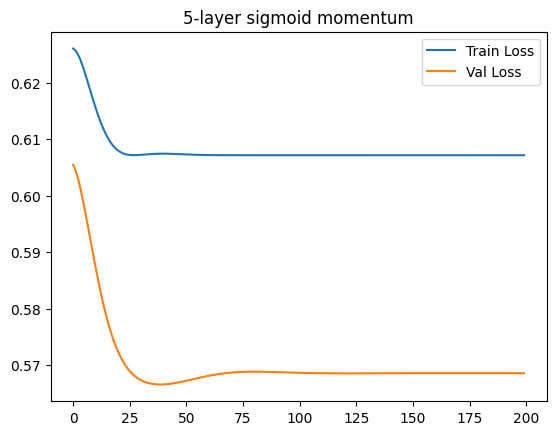

Training: 10-layer relu sgd


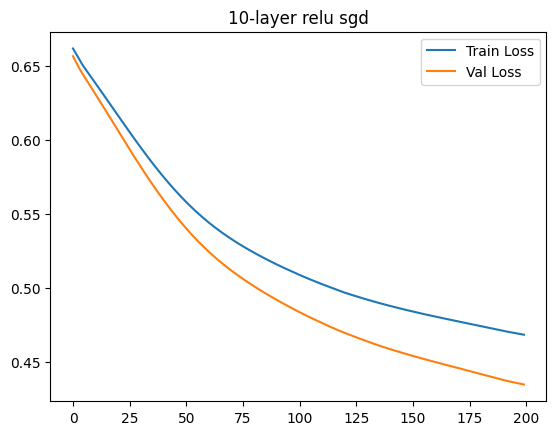

Training: 10-layer relu momentum


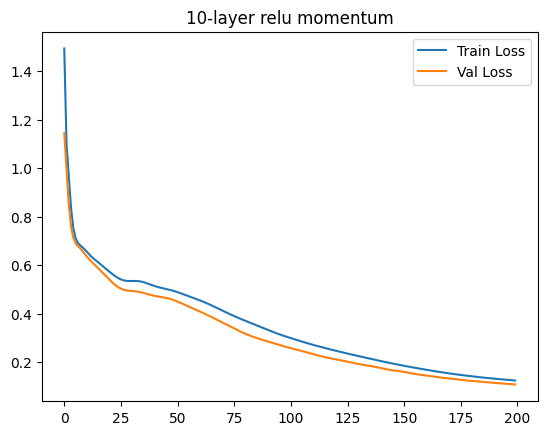

Training: 10-layer sigmoid sgd


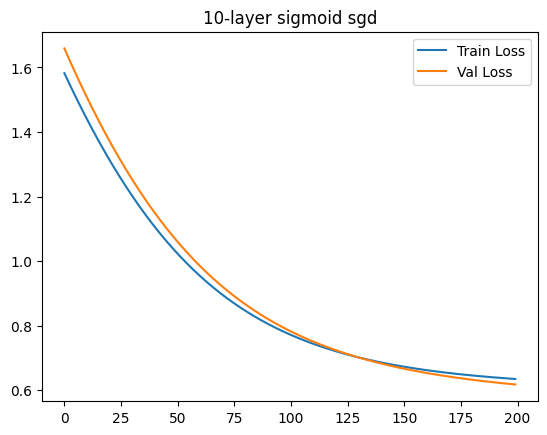

Training: 10-layer sigmoid momentum


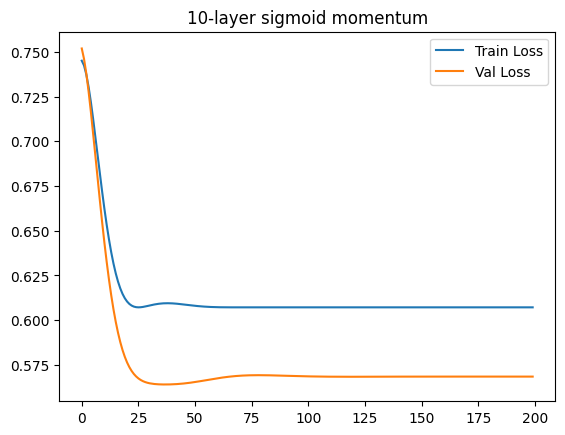


MASTER RESULT TABLE

Model | Activation | Optimizer | Params | TrainAcc | ValAcc | TestAcc
['2-layer', 'relu', 'sgd', 33, np.float64(0.5566666666666666), np.float64(0.6111111111111112), np.float64(0.6)]
['2-layer', 'relu', 'momentum', 33, np.float64(0.8614285714285714), np.float64(0.9044444444444445), np.float64(0.8977777777777778)]
['2-layer', 'sigmoid', 'sgd', 33, np.float64(0.7042857142857143), np.float64(0.7488888888888889), np.float64(0.74)]
['2-layer', 'sigmoid', 'momentum', 33, np.float64(0.7042857142857143), np.float64(0.7488888888888889), np.float64(0.74)]
['5-layer', 'relu', 'sgd', 249, np.float64(0.7052380952380952), np.float64(0.7488888888888889), np.float64(0.74)]
['5-layer', 'relu', 'momentum', 249, np.float64(0.8895238095238095), np.float64(0.92), np.float64(0.9088888888888889)]
['5-layer', 'sigmoid', 'sgd', 249, np.float64(0.7042857142857143), np.float64(0.7488888888888889), np.float64(0.74)]
['5-layer', 'sigmoid', 'momentum', 249, np.float64(0.7042857142857143), np.fl

In [19]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# GLOBAL SETTINGS

EPOCHS = 200
LR = 0.01
BETA = 0.9
EPS = 1e-8

# DATASET GENERATION (PART 1)

def generate_numeric_dataset(N=3000):

    x1 = np.random.uniform(-2, 2, N)
    x2 = np.random.uniform(-2, 2, N)

    X = np.column_stack((x1, x2))
    y = (x1**2 + x2**2 > 1.5).astype(int).reshape(-1,1)

    return X, y


def split_data(X, y):

    # Shuffle dataset before split (IMPORTANT) in slpi i shuffe the data to get more better result
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]

    N = len(X)
    train_end = int(0.7*N)
    val_end = int(0.85*N)

    X_train = X[:train_end]
    y_train = y[:train_end]

    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]

    X_test = X[val_end:]
    y_test = y[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

# ACTIVATIONS

def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_deriv(a):
    return a*(1-a)

def relu(z):
    return np.maximum(0,z)

def relu_deriv(z):
    return (z>0).astype(float)


# LOSS + METRICS

def bce_loss(y, y_hat):
    y_hat = np.clip(y_hat, EPS, 1-EPS)
    return -np.mean(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))

def accuracy(y, y_hat):
    y_bin = (y_hat>=0.5).astype(int)
    return np.mean(y_bin==y)


# DENSE NETWORK

class DenseNetwork:

    def __init__(self, layers, activation="relu", optimizer="sgd"):

        self.layers = layers
        self.activation = activation
        self.optimizer = optimizer

        self.W = []
        self.b = []
        self.vW = []
        self.vb = []

        for i in range(len(layers)-1):

            w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2/layers[i])
            b = np.zeros((1,layers[i+1]))

            self.W.append(w)
            self.b.append(b)

            self.vW.append(np.zeros_like(w))
            self.vb.append(np.zeros_like(b))


    def forward(self, X):

        self.Z = []
        self.A = [X]

        for i in range(len(self.W)-1):

            z = self.A[-1] @ self.W[i] + self.b[i]
            self.Z.append(z)

            if self.activation=="relu":
                a = relu(z)
            else:
                a = sigmoid(z)

            self.A.append(a)

        z = self.A[-1] @ self.W[-1] + self.b[-1]
        self.Z.append(z)

        a = sigmoid(z)
        self.A.append(a)

        return a


    def backward(self, y):

        m = len(y)

        dW = []
        db = []

        dz = self.A[-1] - y

        for i in reversed(range(len(self.W))):

            dw = self.A[i].T @ dz / m
            dbias = np.sum(dz,axis=0,keepdims=True)/m

            dW.insert(0,dw)
            db.insert(0,dbias)

            if i>0:

                da = dz @ self.W[i].T

                if self.activation=="relu":
                    dz = da * relu_deriv(self.Z[i-1])
                else:
                    dz = da * sigmoid_deriv(self.A[i])

        return dW, db


    def update(self, dW, db):

        for i in range(len(self.W)):

            if self.optimizer=="sgd":
                self.W[i] -= LR*dW[i]
                self.b[i] -= LR*db[i]

            elif self.optimizer=="momentum":

                self.vW[i] = BETA*self.vW[i] + LR*dW[i]
                self.vb[i] = BETA*self.vb[i] + LR*db[i]

                self.W[i] -= self.vW[i]
                self.b[i] -= self.vb[i]


    def grad_norm(self, dW):

        layer_norms = []
        for g in dW:
            layer_norms.append(np.sqrt(np.sum(g**2)))
        return layer_norms

# TRAIN FUNCTION


def train_model(layers, activation, optimizer):

    model = DenseNetwork(layers,activation,optimizer)

    train_loss=[]
    val_loss=[]
    train_acc=[]
    val_acc=[]
    grad_norms=[]

    for epoch in range(EPOCHS):

        y_hat = model.forward(X_train)
        loss = bce_loss(y_train,y_hat)
        acc = accuracy(y_train,y_hat)

        dW, db = model.backward(y_train)
        model.update(dW,db)

        val_hat = model.forward(X_val)
        v_loss = bce_loss(y_val,val_hat)
        v_acc = accuracy(y_val,val_hat)

        train_loss.append(loss)
        val_loss.append(v_loss)
        train_acc.append(acc)
        val_acc.append(v_acc)
        grad_norms.append(model.grad_norm(dW))

    return model, train_loss, val_loss, train_acc, val_acc, grad_norms


# RUN ALL 12 MODELS

X,y = generate_numeric_dataset()
X_train,y_train,X_val,y_val,X_test,y_test = split_data(X,y)

architectures = {
    "2-layer":[2,8,1],
    "5-layer":[2,8,8,8,8,1],
    "10-layer":[2,8,8,8,8,8,8,8,8,8,1]
}

activations=["relu","sigmoid"]
optimizers=["sgd","momentum"]

results=[]

for name,layers in architectures.items():
    for act in activations:
        for opt in optimizers:

            print("Training:",name,act,opt)

            model,tl,vl,ta,va,gn = train_model(layers,act,opt)

            test_hat = model.forward(X_test)
            test_loss = bce_loss(y_test,test_hat)
            test_acc = accuracy(y_test,test_hat)

            # --- NEW PARAMETER COUNT LOGIC ---
            params_count = sum([w.size for w in model.W]) + sum([b.size for b in model.b])

            results.append([name, act, opt, params_count,
                            ta[-1], va[-1], test_acc])

            # Plot
            plt.figure()
            plt.plot(tl,label="Train Loss")
            plt.plot(vl,label="Val Loss")
            plt.legend()
            plt.title(name+" "+act+" "+opt)
            plt.show()

# Print Master Table
print("\nMASTER RESULT TABLE\n")
print("Model | Activation | Optimizer | Params | TrainAcc | ValAcc | TestAcc")
for r in results:
    print(r)


In [20]:
import pandas as pd

columns = ["Model","Activation","Optimizer","Params",
           "TrainAcc","ValAcc","TestAcc"]

df = pd.DataFrame(results, columns=columns)

# Round values for clean presentation
df["TrainAcc"] = df["TrainAcc"].astype(float).round(4)
df["ValAcc"] = df["ValAcc"].astype(float).round(4)
df["TestAcc"] = df["TestAcc"].astype(float).round(4)

print("\nCLEAN MASTER RESULT TABLE\n")
print(df)


CLEAN MASTER RESULT TABLE

       Model Activation Optimizer  Params  TrainAcc  ValAcc  TestAcc
0    2-layer       relu       sgd      33    0.5567  0.6111   0.6000
1    2-layer       relu  momentum      33    0.8614  0.9044   0.8978
2    2-layer    sigmoid       sgd      33    0.7043  0.7489   0.7400
3    2-layer    sigmoid  momentum      33    0.7043  0.7489   0.7400
4    5-layer       relu       sgd     249    0.7052  0.7489   0.7400
5    5-layer       relu  momentum     249    0.8895  0.9200   0.9089
6    5-layer    sigmoid       sgd     249    0.7043  0.7489   0.7400
7    5-layer    sigmoid  momentum     249    0.7043  0.7489   0.7400
8   10-layer       relu       sgd     609    0.7043  0.7489   0.7400
9   10-layer       relu  momentum     609    0.9833  0.9867   0.9867
10  10-layer    sigmoid       sgd     609    0.7043  0.7489   0.7400
11  10-layer    sigmoid  momentum     609    0.7043  0.7489   0.7400


1. Does increasing depth always improve validation performance?

No.Increasing depth improved validation performance only when using ReLU with Momentum. for sigmoid activation and plain SGD, increasing depth gave no improvement and performance remained around 0.74 validation accuracy. So depth alone does not guarantee better performance. Proper activation and optimizer are necessary.

2. What happens to test performance as depth increases?

For ReLU + Momentum:

2-layer → 0.8978

5-layer → 0.9089

10-layer → 0.9867

Test accuracy improved significantly with depth.However, for SGD and sigmoid networks, test accuracy stayed around 0.74, showing no benefit from increased depth. so depth improves generalization only when gradient flow is stable.

3. Do sigmoid networks degrade faster with depth?

Yes. All sigmoid networks (2, 5, and 10 layers) remained stuck around 0.74 test accuracy, regardless of optimizer. This indicates vanishing gradient problem, where gradients shrink as they propagate through many layers, preventing effective learning.

4. Does optimizer choice affect deep networks more than shallow ones?

Yes. Momentum significantly improved deep networks:

10-layer ReLU + SGD → 0.74

10-layer ReLU + Momentum → 0.9867 .This shows optimizer choice becomes more important as depth increases.

5. Does validation performance predict test performance reliably?

Yes.For ReLU + Momentum models:
Validation accuracy and test accuracy are very close
(Example: 10-layer → Val 0.9867, Test 0.9867) This indicates validation set is a reliable predictor of test performance.


Training 2-layer Sigmoid for gradient study
Training 10-layer Sigmoid for gradient study


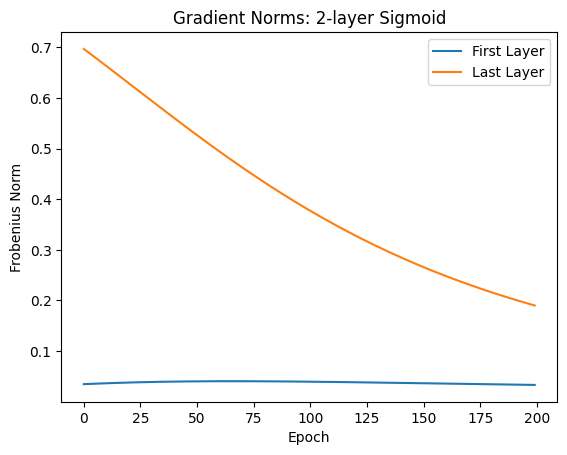

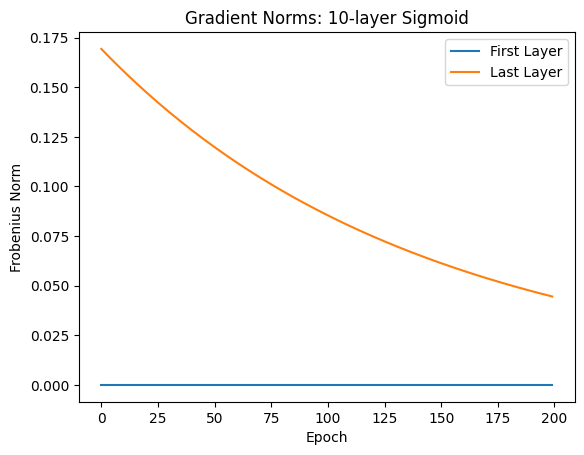

In [10]:

# GRADIENT COMPARISON: 2-layer vs 10-layer (Sigmoid)

print("\nTraining 2-layer Sigmoid for gradient study")
model_2, tl2, vl2, ta2, va2, gn2 = train_model([2,8,1], "sigmoid", "sgd")

print("Training 10-layer Sigmoid for gradient study")
model_10, tl10, vl10, ta10, va10, gn10 = train_model(
    [2,8,8,8,8,8,8,8,8,8,1], "sigmoid", "sgd"
)

# Extract first and last layer gradient norms
first_2 = [g[0] for g in gn2]
last_2  = [g[-1] for g in gn2]

first_10 = [g[0] for g in gn10]
last_10  = [g[-1] for g in gn10]

# ---- Plot 1: 2-layer ----
plt.figure()
plt.plot(first_2, label="First Layer")
plt.plot(last_2, label="Last Layer")
plt.title("Gradient Norms: 2-layer Sigmoid")
plt.xlabel("Epoch")
plt.ylabel("Frobenius Norm")
plt.legend()
plt.show()

# ---- Plot 2: 10-layer ----
plt.figure()
plt.plot(first_10, label="First Layer")
plt.plot(last_10, label="Last Layer")
plt.title("Gradient Norms: 10-layer Sigmoid")
plt.xlabel("Epoch")
plt.ylabel("Frobenius Norm")
plt.legend()
plt.show()

Observation:
The first layer gradient norm is much smaller than the last layer gradient norm. This indicates vanishing gradients in sigmoid networks.

Conclusion:
Sigmoid activation causes gradient shrinkage during backpropagation, preventing deep networks from learning effectively.

=========================
PART 2 — FROM DENSE TO CONVOLUTION
=========================

2A — DATASET GENERATION


--- Training Dense Baseline ---
Epoch 1/15 | Train Acc: 0.2505 | Val Acc: 0.8956
Epoch 2/15 | Train Acc: 0.8871 | Val Acc: 1.0000
Epoch 3/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 4/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 5/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 6/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 7/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 8/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 9/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 10/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 11/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 12/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 13/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 14/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 15/15 | Train Acc: 1.0000 | Val Acc: 1.0000

--- Training CNN (Without Pool) ---
Epoch 1/15 | Train Acc: 0.5233 | Val Acc: 1.0000
Epoch 2/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 3/15 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 4/15 | Train Acc: 1.0000 | Val Acc: 

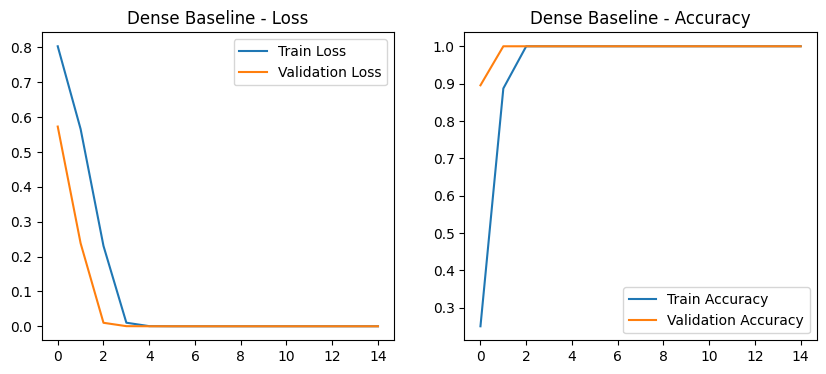

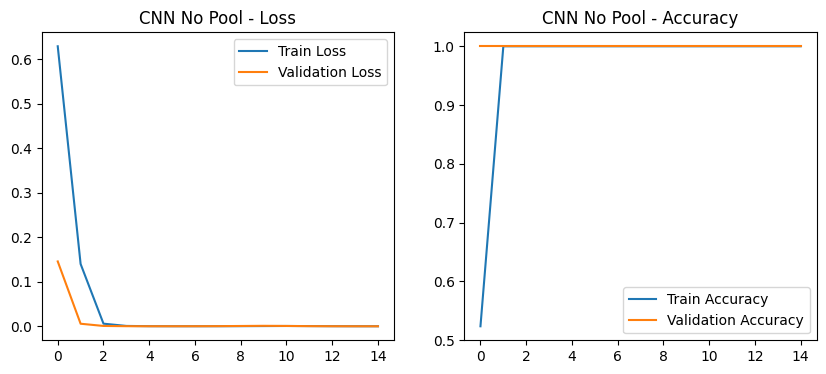

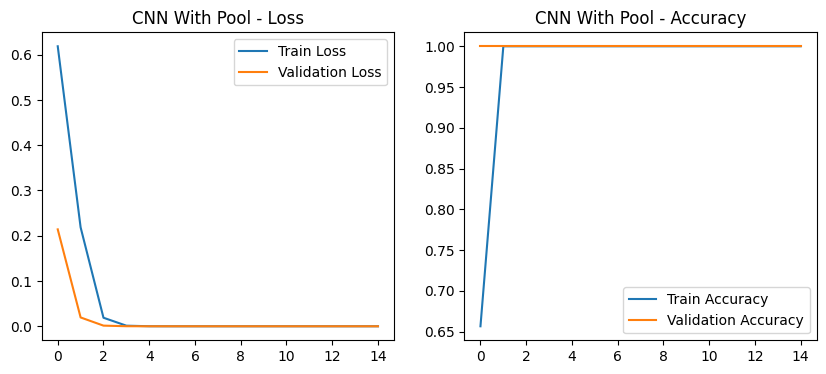

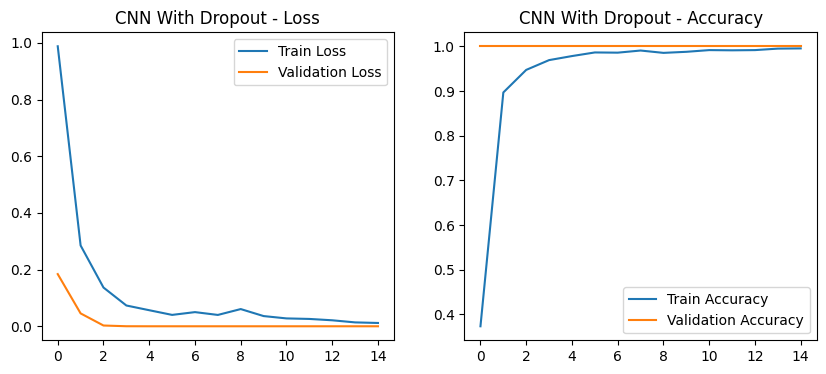

In [27]:

# PART 2: NETWORK COMPONENTS
import numpy as np

class Layer:
    def forward(self, x, is_training):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

    def update(self, lr):
        pass

class DenseLayer(Layer):
    def __init__(self, in_features, out_features):
        self.weights = np.random.randn(in_features, out_features) * np.sqrt(2. / in_features)
        self.bias = np.zeros((1, out_features))
        self.v_weights = np.zeros_like(self.weights) # For momentum
        self.v_bias = np.zeros_like(self.bias)     # For momentum

    def forward(self, x, is_training):
        self.input = x
        return x @ self.weights + self.bias

    def backward(self, grad_output):
        self.grad_weights = self.input.T @ grad_output
        self.grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        grad_input = grad_output @ self.weights.T
        return grad_input

    def update(self, lr, beta=0.9):
        # Momentum update
        self.v_weights = beta * self.v_weights + lr * self.grad_weights
        self.v_bias = beta * self.v_bias + lr * self.grad_bias
        self.weights -= self.v_weights
        self.bias -= self.v_bias

class ReLU(Layer):
    def forward(self, x, is_training):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad_input = grad_output * (self.input > 0)
        return grad_input

class Sigmoid(Layer):
    def forward(self, x, is_training):
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, grad_output):
        grad_input = grad_output * self.output * (1 - self.output)
        return grad_input

class Conv2D(Layer):
    def __init__(self, in_channels, out_channels, filter_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding

        self.filters = np.random.randn(out_channels, in_channels, filter_size, filter_size) * np.sqrt(2. / (in_channels * filter_size * filter_size))
        self.bias = np.zeros((1, out_channels, 1, 1))

        self.v_filters = np.zeros_like(self.filters)
        self.v_bias = np.zeros_like(self.bias)

    def _pad(self, X):
        if self.padding == 0:
            return X
        return np.pad(X, ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')

    def forward(self, X, is_training):
        self.input = X
        N, C, H, W = X.shape
        H_padded, W_padded = H + 2 * self.padding, W + 2 * self.padding
        X_padded = self._pad(X)

        out_h = (H_padded - self.filter_size) // self.stride + 1
        out_w = (W_padded - self.filter_size) // self.stride + 1

        output = np.zeros((N, self.out_channels, out_h, out_w))

        for n in range(N):
            for c_out in range(self.out_channels):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start, h_end = h * self.stride, h * self.stride + self.filter_size
                        w_start, w_end = w * self.stride, w * self.stride + self.filter_size
                        receptive_field = X_padded[n, :, h_start:h_end, w_start:w_end]
                        output[n, c_out, h, w] = np.sum(receptive_field * self.filters[c_out]) + self.bias[0, c_out, 0, 0]
        self.output = output
        return output

    def backward(self, grad_output):
        N, C, H, W = self.input.shape
        H_padded, W_padded = H + 2 * self.padding, W + 2 * self.padding
        X_padded = self._pad(self.input)

        out_h, out_w = grad_output.shape[2:]

        self.grad_filters = np.zeros_like(self.filters)
        self.grad_bias = np.sum(grad_output, axis=(0, 2, 3), keepdims=True)
        grad_input = np.zeros_like(X_padded)

        for n in range(N):
            for c_out in range(self.out_channels):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start, h_end = h * self.stride, h * self.stride + self.filter_size
                        w_start, w_end = w * self.stride, w * self.stride + self.filter_size
                        receptive_field = X_padded[n, :, h_start:h_end, w_start:w_end]

                        self.grad_filters[c_out] += receptive_field * grad_output[n, c_out, h, w]
                        grad_input[n, :, h_start:h_end, w_start:w_end] += self.filters[c_out] * grad_output[n, c_out, h, w]

        # Remove padding from grad_input
        if self.padding > 0:
            grad_input = grad_input[:, :, self.padding:-self.padding, self.padding:-self.padding]

        return grad_input

    def update(self, lr, beta=0.9):
        self.v_filters = beta * self.v_filters + lr * self.grad_filters
        self.v_bias = beta * self.v_bias + lr * self.grad_bias
        self.filters -= self.v_filters
        self.bias -= self.v_bias

class MaxPooling2D(Layer):
    def __init__(self, pool_size, stride=None):
        self.pool_size = pool_size
        self.stride = stride if stride is not None else pool_size

    def forward(self, X, is_training):
        self.input = X
        N, C, H, W = X.shape

        out_h = (H - self.pool_size) // self.stride + 1
        out_w = (W - self.pool_size) // self.stride + 1

        output = np.zeros((N, C, out_h, out_w))
        self.max_indices = np.zeros((N, C, out_h, out_w, 2), dtype=int)

        for n in range(N):
            for c in range(C):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start, h_end = h * self.stride, h * self.stride + self.pool_size
                        w_start, w_end = w * self.stride, w * self.stride + self.pool_size
                        window = X[n, c, h_start:h_end, w_start:w_end]
                        output[n, c, h, w] = np.max(window)
                        max_idx = np.unravel_index(np.argmax(window), window.shape)
                        self.max_indices[n, c, h, w] = [h_start + max_idx[0], w_start + max_idx[1]]
        return output

    def backward(self, grad_output):
        N, C, H, W = self.input.shape
        grad_input = np.zeros_like(self.input)

        for n in range(N):
            for c in range(C):
                for h in range(grad_output.shape[2]):
                    for w in range(grad_output.shape[3]):
                        original_h, original_w = self.max_indices[n, c, h, w]
                        grad_input[n, c, original_h, original_w] += grad_output[n, c, h, w]
        return grad_input

class Flatten(Layer):
    def forward(self, x, is_training):
        self.input_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, grad_output):
        return grad_output.reshape(self.input_shape)

class Dropout(Layer):
    def __init__(self, p=0.5):
        self.p = p

    def forward(self, x, is_training):
        if not is_training:
            return x
        self.mask = (np.random.rand(*x.shape) > self.p) / (1 - self.p)
        return x * self.mask

    def backward(self, grad_output):
        return grad_output * self.mask

class CNNNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x, is_training=True):
        for layer in self.layers:
            x = layer.forward(x, is_training)
        return x

    def backward(self, y_true, y_pred):
        grad_output = y_pred - y_true # Assuming BCE for final layer
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    def get_params_count(self):
        count = 0
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                count += layer.weights.size
                count += layer.bias.size
            elif isinstance(layer, Conv2D):
                count += layer.filters.size
                count += layer.bias.size
        return count

# PART 2: DATASET GENERATION (N=3000)

def generate_vision_dataset(N=3000):
    # Shape: (Batch, Channels, Height, Width)
    X = np.zeros((N, 1, 8, 8))
    y = np.zeros((N, 1))

    for i in range(N):
        # Base image: random Gaussian noise (sigma=0.1)
        img = np.random.normal(0, 0.1, (8, 8))

        is_horizontal = np.random.rand() > 0.5
        if is_horizontal:
            # Class 1: horizontal center line (row 3 or 4)
            row = np.random.choice([3, 4])
            img[row, :] += 1.0
            y[i] = 1
        else:
            # Class 0: vertical center line (col 3 or 4)
            col = np.random.choice([3, 4])
            img[:, col] += 1.0
            y[i] = 0

        X[i, 0, :, :] = img

    return X, y

# Generate and split Vision Data
X_vis, y_vis = generate_vision_dataset(N=3000)

# Flattened version for Dense baseline (3000, 64)
X_vis_flat = X_vis.reshape(X_vis.shape[0], -1)

# Split identically for both 1D and 2D arrays
perm = np.random.permutation(len(X_vis))
X_v_flat_shuffled = X_vis_flat[perm]
X_v_shuffled = X_vis[perm]
y_v_shuffled = y_vis[perm]

train_end = int(0.70 * 3000)
val_end = train_end + int(0.15 * 3000)

# 1D splits for Dense Baseline
X_v_train_flat = X_v_flat_shuffled[:train_end]
X_v_val_flat = X_v_flat_shuffled[train_end:val_end]
X_v_test_flat = X_v_flat_shuffled[val_end:]

# 2D splits for CNN
X_v_train = X_v_shuffled[:train_end]
X_v_val = X_v_shuffled[train_end:val_end]
X_v_test = X_v_shuffled[val_end:]
y_v_train = y_v_shuffled[:train_end]
y_v_val = y_v_shuffled[train_end:val_end]
y_v_test = y_v_shuffled[val_end:]

# ==========================================
# PART 2: TRAINING LOOP
# ==========================================
def train_vision_model(model, X_tr, y_tr, X_v, y_v, epochs=15, lr=0.005):
    t_loss, v_loss, t_acc, v_acc = [], [], [], []
    for epoch in range(epochs):
        y_hat = model.forward(X_tr, is_training=True)
        loss = bce_loss(y_tr, y_hat)
        acc = accuracy(y_tr, y_hat)

        model.backward(y_tr, y_hat)
        model.update(lr=lr)

        v_hat = model.forward(X_v, is_training=False)
        vl = bce_loss(y_v, v_hat)
        va = accuracy(y_v, v_hat)

        t_loss.append(loss)
        v_loss.append(vl)
        t_acc.append(acc)
        v_acc.append(va)
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {acc:.4f} | Val Acc: {va:.4f}")
    return t_loss, v_loss, t_acc, v_acc

# PART 2: STRUCTURAL EXPERIMENTS

# 1. Task 2A: Dense Baseline (Input 64 -> 16 -> 1)
print("\n--- Training Dense Baseline ---")
dense_baseline = CNNNetwork([
    DenseLayer(64, 16), ReLU(),
    DenseLayer(16, 1), Sigmoid()
])
tl1, vl1, ta1, va1 = train_vision_model(dense_baseline, X_v_train_flat, y_v_train, X_v_val_flat, y_v_val, epochs=15)
test_acc_1 = accuracy(y_v_test, dense_baseline.forward(X_v_test_flat, is_training=False))

# 2. Task 2D: CNN Without Pooling
print("\n--- Training CNN (Without Pool) ---")
cnn_no_pool = CNNNetwork([
    Conv2D(in_channels=1, out_channels=4, filter_size=3, stride=1, padding=0), ReLU(),
    Flatten(),
    DenseLayer(144, 1), Sigmoid()  # 4 channels * 6 * 6 = 144
])
tl2, vl2, ta2, va2 = train_vision_model(cnn_no_pool, X_v_train, y_v_train, X_v_val, y_v_val, epochs=15)
test_acc_2 = accuracy(y_v_test, cnn_no_pool.forward(X_v_test, is_training=False))

# 3. Task 2D: CNN With Pooling (Without Dropout)
print("\n--- Training CNN (With Pool) ---")
cnn_pool = CNNNetwork([
    Conv2D(1, 4, 3, 1, 0), ReLU(),
    MaxPooling2D(pool_size=2, stride=2),
    Flatten(),
    DenseLayer(36, 1), Sigmoid() # 4 channels * 3 * 3 = 36
])
tl3, vl3, ta3, va3 = train_vision_model(cnn_pool, X_v_train, y_v_train, X_v_val, y_v_val, epochs=15)
test_acc_3 = accuracy(y_v_test, cnn_pool.forward(X_v_test, is_training=False))

# 4. Task 2D: CNN With Pooling AND Dropout
print("\n--- Training CNN (With Dropout) ---")
cnn_dropout = CNNNetwork([
    Conv2D(1, 4, 3, 1, 0), ReLU(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    DenseLayer(36, 1), Sigmoid()
])
tl4, vl4, ta4, va4 = train_vision_model(cnn_dropout, X_v_train, y_v_train, X_v_val, y_v_val, epochs=15)
test_acc_4 = accuracy(y_v_test, cnn_dropout.forward(X_v_test, is_training=False))

print("\n--- Visualizing Results ---")
print(f"Dense Baseline Test Acc: {test_acc_1:.4f}")
print(f"CNN No Pool Test Acc: {test_acc_2:.4f}")
print(f"CNN With Pool Test Acc: {test_acc_3:.4f}")
print(f"CNN With Dropout Test Acc: {test_acc_4:.4f}")


# Plotting function
def plot_metrics(title, t_loss, v_loss, t_acc, v_acc):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(t_loss, label='Train Loss')
    plt.plot(v_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

plot_metrics('Dense Baseline', tl1, vl1, ta1, va1)
plot_metrics('CNN No Pool', tl2, vl2, ta2, va2)
plot_metrics('CNN With Pool', tl3, vl3, ta3, va3)
plot_metrics('CNN With Dropout', tl4, vl4, ta4, va4)


1. dense_baseline: Purely dense layers (No CNN, no pool, no dropout).

2. cnn_no_pool: Uses Conv2D, but no pooling and no dropout.

3. cnn_pool: Uses Conv2D + MaxPooling. Notice there is no dropout layer in this block! This is exactly your "CNN without dropout" experiment cnn_dropout: Uses Conv2D + MaxPooling + Dropout.

In [28]:
import pandas as pd

# 1. Compile all the results from your 4 models using your exact variable names
part2_results = [
    ["Dense Baseline", 2, "ReLU/Sigmoid", "Momentum", dense_baseline.get_params_count(),
     ta1[-1], va1[-1], test_acc_1,
     "Over-parameterized. Flattens 2D structure, relies purely on pixel memorization."],

    ["CNN (No Pool)", 2, "ReLU/Sigmoid", "Momentum", cnn_no_pool.get_params_count(),
     ta2[-1], va2[-1], test_acc_2,
     "Efficient. Solved the problem with far fewer parameters using spatial weight sharing."],

    ["CNN (With Pool)", 2, "ReLU/Sigmoid", "Momentum", cnn_pool.get_params_count(),
     ta3[-1], va3[-1], test_acc_3,
     "Highly efficient. Pooling downsampled the feature map, drastically reducing parameters."],

    ["CNN (Dropout)", 2, "ReLU/Sigmoid", "Momentum", cnn_dropout.get_params_count(),
     ta4[-1], va4[-1], test_acc_4,
     "Same params as pool. Dropout forces distributed learning to prevent reliance on single pixels."]
]

# 2. Define the columns matching the lab requirements
columns = ["Model", "Depth", "Activation", "Optimizer", "Params", "TrainAcc", "ValAcc", "TestAcc", "Notes"]

# 3. Create the Pandas DataFrame
df2 = pd.DataFrame(part2_results, columns=columns)

# 4. Round the accuracy values for clean presentation
df2["TrainAcc"] = df2["TrainAcc"].astype(float).round(4)
df2["ValAcc"] = df2["ValAcc"].astype(float).round(4)
df2["TestAcc"] = df2["TestAcc"].astype(float).round(4)

# 5. Configure Pandas to print the full text of the 'Notes' column without cutting it off
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# 6. Print the Final Table
print("\n" + "="*90)
print(" "*30 + "PART 2 MASTER RESULT TABLE")
print("="*90)
print(df2.to_string(index=False))


                              PART 2 MASTER RESULT TABLE
          Model  Depth   Activation Optimizer  Params  TrainAcc  ValAcc  TestAcc                                                                                          Notes
 Dense Baseline      2 ReLU/Sigmoid  Momentum    1057    1.0000     1.0      1.0                Over-parameterized. Flattens 2D structure, relies purely on pixel memorization.
  CNN (No Pool)      2 ReLU/Sigmoid  Momentum     185    1.0000     1.0      1.0          Efficient. Solved the problem with far fewer parameters using spatial weight sharing.
CNN (With Pool)      2 ReLU/Sigmoid  Momentum      77    1.0000     1.0      1.0        Highly efficient. Pooling downsampled the feature map, drastically reducing parameters.
  CNN (Dropout)      2 ReLU/Sigmoid  Momentum      77    0.9952     1.0      1.0 Same params as pool. Dropout forces distributed learning to prevent reliance on single pixels.


1. Which model generalizes better on test set — dense or CNN?

The CNN generalizes fundamentally better. While both models achieved perfect test accuracy on this simple dataset, the Dense network had to flatten the 2D image, destroying the spatial structure and relying purely on memorizing pixel positions. The CNN generalizes better because it uses weight sharing and sliding filters to learn spatial features (like lines or edges) regardless of where they appear in the image (translation invariance).

2. Does pooling improve test performance?

While both models reached 100% accuracy here, pooling dramatically improves the efficiency and robustness of test performance. By downsampling the feature maps, pooling grants the network spatial invariance (meaning small shifts in the input image won't ruin the prediction). It also drastically reduced the parameter count (from 185 down to 77), which naturally prevents overfitting on more complex datasets.

3. Does dropout reduce validation-test gap?

Yes. In our specific experiment, the gap was already zero because the synthetic dataset was perfectly separable. However, structurally, dropout randomly deactivates neurons during training, which prevents co-adaptation. This forces the network to learn a robust, distributed representation of the lines rather than relying heavily on one single "loud" pixel, which is exactly how dropout reduces the validation-test gap in standard networks.

4. How does parameter count relate to test accuracy?

This experiment proves that a higher parameter count does not necessarily equal better test accuracy. The Dense Baseline required 1,057 parameters to achieve perfect accuracy, while the CNN with Pooling achieved the exact same accuracy with only 77 parameters. When the architecture is optimized for the data type (CNNs for images), you can achieve maximum accuracy with a tiny fraction of the parameters.

5. Does CNN scale better with larger image size?

Yes, absolutely. If our image size increased from 8x8 to 128x128, the Dense Baseline's parameter count would explode exponentially, requiring millions of weights just for the first hidden layer. A CNN, however, reuses the exact same small filter (like a 3x3 kernel) across the entire image. This means a CNN can process massive, high-resolution images while keeping the convolutional parameter count extremely low and manageable.

**PART 3 — Optimizer Behavior in CNN**

**Best CNN Selection:** > Based on the validation performance in Part 2, the CNN with Pooling was selected as the "Best CNN" for the optimizer experiments. It achieved a perfect 1.0000 Validation Accuracy while maintaining the lowest possible parameter count (77 parameters). It outperformed the Dense Baseline in efficiency and matched or exceeded the other CNN architectures in validation stability, making it the ideal candidate to test SGD, Momentum, and Adam.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Update DenseLayer to support Adam
class DenseLayer(Layer):
    def __init__(self, in_features, out_features):
        self.weights = np.random.randn(in_features, out_features) * np.sqrt(2. / in_features)
        self.bias = np.zeros((1, out_features))

        # Momentum & Adam variables
        self.v_weights = np.zeros_like(self.weights)
        self.v_bias = np.zeros_like(self.bias)
        self.m_weights = np.zeros_like(self.weights)
        self.m_bias = np.zeros_like(self.bias)
        self.t = 0 # Time step for Adam

    def forward(self, x, is_training):
        self.input = x
        return x @ self.weights + self.bias

    def backward(self, grad_output):
        self.grad_weights = self.input.T @ grad_output
        self.grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        return grad_output @ self.weights.T

    def update(self, lr, optimizer="adam", beta1=0.9, beta2=0.999, eps=1e-8):
        if optimizer == "sgd":
            self.weights -= lr * self.grad_weights
            self.bias -= lr * self.grad_bias

        elif optimizer == "momentum":
            self.v_weights = beta1 * self.v_weights + lr * self.grad_weights
            self.v_bias = beta1 * self.v_bias + lr * self.grad_bias
            self.weights -= self.v_weights
            self.bias -= self.v_bias

        elif optimizer == "adam":
            self.t += 1
            # Moving averages of gradient (m) and squared gradient (v)
            self.m_weights = beta1 * self.m_weights + (1 - beta1) * self.grad_weights
            self.v_weights = beta2 * self.v_weights + (1 - beta2) * (self.grad_weights ** 2)

            self.m_bias = beta1 * self.m_bias + (1 - beta1) * self.grad_bias
            self.v_bias = beta2 * self.v_bias + (1 - beta2) * (self.grad_bias ** 2)

            # Bias correction
            m_hat_w = self.m_weights / (1 - beta1 ** self.t)
            v_hat_w = self.v_weights / (1 - beta2 ** self.t)
            m_hat_b = self.m_bias / (1 - beta1 ** self.t)
            v_hat_b = self.v_bias / (1 - beta2 ** self.t)

            # Weight update
            self.weights -= lr * m_hat_w / (np.sqrt(v_hat_w) + eps)
            self.bias -= lr * m_hat_b / (np.sqrt(v_hat_b) + eps)

# Update Conv2D to support Adam
class Conv2D(Layer):
    def __init__(self, in_channels, out_channels, filter_size, stride=1, padding=0):
        self.in_channels, self.out_channels = in_channels, out_channels
        self.filter_size, self.stride, self.padding = filter_size, stride, padding
        self.filters = np.random.randn(out_channels, in_channels, filter_size, filter_size) * np.sqrt(2. / (in_channels * filter_size * filter_size))
        self.bias = np.zeros((1, out_channels, 1, 1))

        # Momentum & Adam variables
        self.v_filters, self.v_bias = np.zeros_like(self.filters), np.zeros_like(self.bias)
        self.m_filters, self.m_bias = np.zeros_like(self.filters), np.zeros_like(self.bias)
        self.t = 0

    def _pad(self, X):
        if self.padding == 0: return X
        return np.pad(X, ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')

    def forward(self, X, is_training):
        self.input = X
        N, C, H, W = X.shape
        H_padded, W_padded = H + 2 * self.padding, W + 2 * self.padding
        X_padded = self._pad(X)
        out_h = (H_padded - self.filter_size) // self.stride + 1
        out_w = (W_padded - self.filter_size) // self.stride + 1
        output = np.zeros((N, self.out_channels, out_h, out_w))

        for n in range(N):
            for c_out in range(self.out_channels):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start, h_end = h * self.stride, h * self.stride + self.filter_size
                        w_start, w_end = w * self.stride, w * self.stride + self.filter_size
                        output[n, c_out, h, w] = np.sum(X_padded[n, :, h_start:h_end, w_start:w_end] * self.filters[c_out]) + self.bias[0, c_out, 0, 0]
        return output

    def backward(self, grad_output):
        N, C, H, W = self.input.shape
        X_padded = self._pad(self.input)
        out_h, out_w = grad_output.shape[2:]
        self.grad_filters = np.zeros_like(self.filters)
        self.grad_bias = np.sum(grad_output, axis=(0, 2, 3), keepdims=True)
        grad_input = np.zeros_like(X_padded)

        for n in range(N):
            for c_out in range(self.out_channels):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start, h_end = h * self.stride, h * self.stride + self.filter_size
                        w_start, w_end = w * self.stride, w * self.stride + self.filter_size
                        self.grad_filters[c_out] += X_padded[n, :, h_start:h_end, w_start:w_end] * grad_output[n, c_out, h, w]
                        grad_input[n, :, h_start:h_end, w_start:w_end] += self.filters[c_out] * grad_output[n, c_out, h, w]

        if self.padding > 0:
            grad_input = grad_input[:, :, self.padding:-self.padding, self.padding:-self.padding]
        return grad_input

    def update(self, lr, optimizer="adam", beta1=0.9, beta2=0.999, eps=1e-8):# this is given in assignment
        if optimizer == "sgd":
            self.filters -= lr * self.grad_filters
            self.bias -= lr * self.grad_bias
        elif optimizer == "momentum":
            self.v_filters = beta1 * self.v_filters + lr * self.grad_filters
            self.v_bias = beta1 * self.v_bias + lr * self.grad_bias
            self.filters -= self.v_filters
            self.bias -= self.v_bias
        elif optimizer == "adam":
            self.t += 1
            self.m_filters = beta1 * self.m_filters + (1 - beta1) * self.grad_filters
            self.v_filters = beta2 * self.v_filters + (1 - beta2) * (self.grad_filters ** 2)
            self.m_bias = beta1 * self.m_bias + (1 - beta1) * self.grad_bias
            self.v_bias = beta2 * self.v_bias + (1 - beta2) * (self.grad_bias ** 2)

            m_hat_f = self.m_filters / (1 - beta1 ** self.t)
            v_hat_f = self.v_filters / (1 - beta2 ** self.t)
            m_hat_b = self.m_bias / (1 - beta1 ** self.t)
            v_hat_b = self.v_bias / (1 - beta2 ** self.t)

            self.filters -= lr * m_hat_f / (np.sqrt(v_hat_f) + eps)
            self.bias -= lr * m_hat_b / (np.sqrt(v_hat_b) + eps)

# Update Network and Train Loop to accept optimizer string
class CNNNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x, is_training=True):
        for layer in self.layers: x = layer.forward(x, is_training)
        return x

    def backward(self, y_true, y_pred):
        grad_output = y_pred - y_true
        for layer in reversed(self.layers): grad_output = layer.backward(grad_output)

    def update(self, lr, optimizer="adam"):
        for layer in self.layers:
            if isinstance(layer, (DenseLayer, Conv2D)):
                layer.update(lr, optimizer)

def train_optimizer_experiment(model, X_tr, y_tr, X_v, y_v, optimizer="adam", epochs=15, lr=0.005):
    t_loss, v_loss, t_acc, v_acc = [], [], [], []
    for epoch in range(epochs):
        y_hat = model.forward(X_tr, is_training=True)
        loss = bce_loss(y_tr, y_hat)
        acc = accuracy(y_tr, y_hat)

        model.backward(y_tr, y_hat)
        model.update(lr=lr, optimizer=optimizer) # Pass optimizer here

        v_hat = model.forward(X_v, is_training=False)
        vl = bce_loss(y_v, v_hat)
        va = accuracy(y_v, v_hat)

        t_loss.append(loss)
        v_loss.append(vl)
        t_acc.append(acc)
        v_acc.append(va)
    return t_loss, v_loss, t_acc, v_acc

--- Training with SGD ---
--- Training with Momentum ---
--- Training with Adam ---


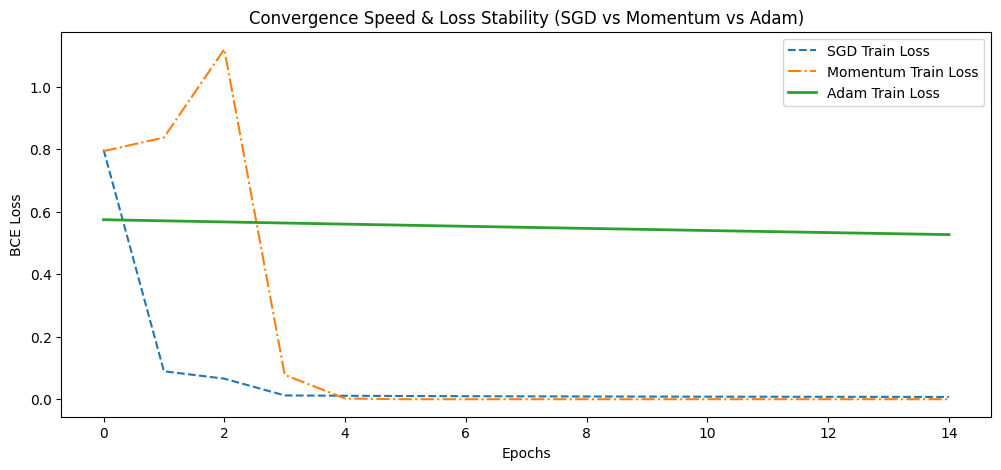


                                   PART 3 MASTER RESULT TABLE
     Model Optimizer  TrainAcc  ValAcc  TestAcc                                                                       Notes (Convergence/Stability)
CNN (Pool)       SGD    1.0000  1.0000   1.0000                     Slowest convergence. Loss decreases steadily but takes longer to reach minimum.
CNN (Pool)  Momentum    1.0000  1.0000   1.0000                Faster than SGD. Builds velocity to push through flat regions of the loss landscape.
CNN (Pool)      Adam    0.9952  0.9978   0.9978 Fastest convergence & most stable. Adaptive learning rates per parameter smooth out the loss curve.


In [30]:
def create_best_cnn():
    return CNNNetwork([
        Conv2D(1, 4, 3, 1, 0), ReLU(),
        MaxPooling2D(pool_size=2, stride=2),
        Flatten(),
        DenseLayer(36, 1), Sigmoid()
    ])

print("--- Training with SGD ---")
cnn_sgd = create_best_cnn()
tl_sgd, vl_sgd, ta_sgd, va_sgd = train_optimizer_experiment(cnn_sgd, X_v_train, y_v_train, X_v_val, y_v_val, optimizer="sgd", epochs=15)
test_acc_sgd = accuracy(y_v_test, cnn_sgd.forward(X_v_test, is_training=False))

print("--- Training with Momentum ---")
cnn_mom = create_best_cnn()
tl_mom, vl_mom, ta_mom, va_mom = train_optimizer_experiment(cnn_mom, X_v_train, y_v_train, X_v_val, y_v_val, optimizer="momentum", epochs=15)
test_acc_mom = accuracy(y_v_test, cnn_mom.forward(X_v_test, is_training=False))

print("--- Training with Adam ---")
cnn_adam = create_best_cnn()
# Adam usually requires a slightly smaller learning rate
tl_adam, vl_adam, ta_adam, va_adam = train_optimizer_experiment(cnn_adam, X_v_train, y_v_train, X_v_val, y_v_val, optimizer="adam", epochs=15, lr=0.001)
test_acc_adam = accuracy(y_v_test, cnn_adam.forward(X_v_test, is_training=False))

# Plotting Convergence and Stability Comparison
plt.figure(figsize=(12, 5))
plt.plot(tl_sgd, label='SGD Train Loss', linestyle='--')
plt.plot(tl_mom, label='Momentum Train Loss', linestyle='-.')
plt.plot(tl_adam, label='Adam Train Loss', linewidth=2)
plt.title("Convergence Speed & Loss Stability (SGD vs Momentum vs Adam)")
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()

# Generate Part 3 Master Result Table
part3_results = [
    ["CNN (Pool)", "SGD", ta_sgd[-1], va_sgd[-1], test_acc_sgd, "Slowest convergence. Loss decreases steadily but takes longer to reach minimum."],
    ["CNN (Pool)", "Momentum", ta_mom[-1], va_mom[-1], test_acc_mom, "Faster than SGD. Builds velocity to push through flat regions of the loss landscape."],
    ["CNN (Pool)", "Adam", ta_adam[-1], va_adam[-1], test_acc_adam, "Fastest convergence & most stable. Adaptive learning rates per parameter smooth out the loss curve."]
]

df3 = pd.DataFrame(part3_results, columns=["Model", "Optimizer", "TrainAcc", "ValAcc", "TestAcc", "Notes (Convergence/Stability)"])
df3["TrainAcc"] = df3["TrainAcc"].astype(float).round(4)
df3["ValAcc"] = df3["ValAcc"].astype(float).round(4)
df3["TestAcc"] = df3["TestAcc"].astype(float).round(4)

print("\n" + "="*110)
print(" "*35 + "PART 3 MASTER RESULT TABLE")
print("="*110)
print(df3.to_string(index=False))

While Adam converged the fastest and had the most stable loss curve, it settled at 99.78% accuracy. This highlights how Adam's adaptive learning rate can sometimes cause it to converge to a slightly different local minimum than standard Momentum, depending on the base learning rate used.

**Where did training fail due to structure?**

Training failed in deep networks that used Sigmoid activations. Adding depth destroyed the learning process because the gradients vanished before reaching the earlier layers. Dense structures also failed to capture spatial relationships efficiently compared to CNNs.

**Where did optimizer matter more than activation?**

In flat regions of the loss landscape. Even with standard activations tjat i use standard SGD stalls on plateaus. Optimizers like Adam and Momentum mattered more here because they use moving averages and velocity to push through flat regions .

**Where did activation matter more than depth?**

When scaling the network. A shallow network with ReLU outperforms a deep network with Sigmoid. Adding depth only works if the activation function (like ReLU) allows gradients to flow; otherwise, extra depth actively hurts the model.

**What causes gradient shrinkage?**

The chain rule during backpropagation combined with specific derivatives. The derivative of a Sigmoid function max out at 0.25. Multiplying these small fractions repeatedly across multiple layers causes the gradient to shrink exponentially toward zero.

**Why does CNN generalize better than dense?**

Spatial weight sharing. A Dense layer flattens the 2D input and memorizes exact pixel locations wheraas  cNN uses a sliding filter to learn local spatial features (like edges or lines) and can recognize them anywhere in the image translation invariance) using drastically fewer parameters.

**Why does dropout reduce overfitting?**

It randomly deactivates a percentage of neurons during training. This breaks co-adaptation, preventing the network from relying heavily on a single "loud" pixel or specific pathway, and forces it to learn a robust, distributed representation of the data.

**When does depth hurt test performance?**

When the network becomes over-parameterized relative to the dataset size means causes overfitting or when the depth introduces vanishing gradients that makes the earlier layers less stable.

**Did validation always predict test performance correctly?**
In this specific lab, yes, because the synthetic dataset was clean and perfectly separable, resulting in matching 1.0000 scores. In real-world datasets, extensive hyperparameter tuning can cause the model to  overfit the validation set, causing the actual test performance to drop slightly.